# Трассировка лучей


## Подключаем библиотеки и описываем вспомогательные функции

In [285]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

eps = 2**(-10)
tiny_eps = 2**(-15)

class empty():
    def __init__(self):
        return None
    
class endles_none:
    def __init__(self, n):
        self.n = n
        return None
    def __iter__(self):
        return endles_none(self.n)
    def __next__(self):
        if self.n <= 0:
            raise StopIteration
        else:
            self.n -= 1
        return None
    
def none_func(n):
    def function(*args, **kwargs):
        if n > 1:
            return endles_none(n)
        elif n == 1:
            return None
        else:
            raise ValueError
    return function

def const_func(const):
    def function(*args, **kwargs):
        return const
    return function

def normalize(x):
    x /= np.linalg.norm(x)
    return x

def smooth_max(x, y, alpha):
    return (x*np.exp(alpha*x) + y*np.exp(alpha*y))/(np.exp(alpha*x) + np.exp(alpha*y))

def V3_gradient(func, point):
    x = np.array([1.,0,0])
    y = np.array([0,1.,0])
    z = np.array([0,0,1.])
    return np.array([(func(point+eps*x) - func(point-eps*x))/(2*eps),
                     (func(point+eps*y) - func(point-eps*y))/(2*eps),
                     (func(point+eps*z) - func(point-eps*z))/(2*eps)])
    

## Алгоритмы отрисовки и трассировки

In [286]:
def render_image (camera, scene, screen, *, status = 5, depth=5):
    w = screen.w
    h = screen.h
    
    image = np.zeros((h, w, 3))
    
    # ----- status output -----
    procents = 0
    if 0 < status <= 100:
        print(0,'%')
        start_t = time.time()
        last_t = start_t
        
    for i in range(h):
        for k in range(w):
            pixel_pos = camera.position + camera.orientate + camera.delta*(camera.dx*(k - w/2) + camera.dy*(h/2 - i))
            ray = normalize(pixel_pos - camera.position)
            
            image[i][k] = trace_ray(scene, pixel_pos, ray, depth)
        
        # ----- status output -----
        if 0 < status <= 100:
            if procents < ((i/h)*100) // status:
                tmp = time.time()
                print(i/h*100,'% dt -', tmp - last_t)
                last_t = tmp
                procents = ((i/h)*100) // status
    # ----- status output -----
    if 0 < status <= 100:
        end_t = time.time()
        print(100,'% time -', end_t - start_t)
    
    return image

def trace_ray (scene, start, ray, depth=5, significance=1, weight=1):
    ans = np.zeros(3)
    if depth <= 0:
        return ans

    light = np.array([3.0, 6, -10.0])
    
    color = np.ones((3))
    alpha = 0.4
    normal, dist = scene.get_normal(start, ray)
    if normal is not None:
        point = start + ray*dist
        if point[1] < eps:
            color = np.cos(point)**2;
            alpha = 0.8;
        else:
            color = np.ones((3))
            alpha = 0.3;
            
        tmp = np.sum(normalize(light-point) * normal)
        if tmp < 0:
            tmp *= -1
        _, light_dist = scene.get_normal(point + normalize(light-point)*eps, normalize(light-point))
        if light_dist > np.linalg.norm(light-point):
            ans += color * tmp * alpha
            
        if (1-alpha) > 0:
            ray -= 2*normal*np.sum(normal*ray)
            ans += (1-alpha) *trace_ray(scene, point + eps*ray, ray, depth-1)
    return ans

## Описание объектов сцены

In [287]:
class render_object:
    def __init__(self, *args, **kwargs):
        if 'get_normal' in kwargs.keys():
            self.get_normal = kwargs['get_normal']
        if 'get_intersection' in kwargs.keys():
            self.get_intersection = kwargs['get_intersection']
        if 'get_color' in kwargs.keys():
            self.get_color = kwargs['get_color']
        return None

class scene:
    def __init__(self, render_objects):
        self.objects = render_objects
        self.last_object = None
        return None
    
    def get_normal(self, start, ray):
        normal = None
        distance = np.inf
        for obj in self.objects:
            tmp_normal, tmp_distance = obj.get_normal(start, ray)
            if tmp_distance < distance:
                distance = tmp_distance
                normal = tmp_normal
        return normal, distance

def sphere(Position, R):
    def normal(start, ray):
        a = np.dot(ray, ray)
        PS = start - Position
        b = 2 * np.dot(ray, PS)
        c = np.dot(PS, PS) - R * R
        disc = b * b - 4 * a * c
        if disc > 0:
            distSqrt = np.sqrt(disc)
            q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
            t0 = q / a
            t1 = c / q
            t0, t1 = min(t0, t1), max(t0, t1)
            if t1 >= 0:
                if t0 < 0:
                    return normalize(start + ray*t1 - Position), t1
                else:
                    return normalize(start + ray*t0 - Position), t0
        return None, np.inf
    return normal

def plane(Position, Direction):
    Direction = normalize(Direction)
    def normal(start, ray):
        if np.sum((Position - start) * Direction) * np.sum(ray * Direction) <= 0:
            return None, np.inf
        else:
            return Direction, np.sum((Position - start) * Direction)/np.sum(ray * Direction)
    return normal

### Описание SDF с потдержкой CSG и преобразования SDF в объкты

In [ ]:
class SDF_function:
    def __init__(self, func, gradient=None):
        self.distance = func
        if gradient is not None:
            def grad(*args, **kwargs):
                return gradient(func, *args, **kwargs)
            self.gradient = grad
        return None
    
    def add_gradient(self, gradient=None):
        def grad(*args, **kwargs):
            return gradient(self.distance, *args, **kwargs)
        self.gradient = grad
        return self
    
    def __call__(self, *args, **kwargs):
        return self.distance(*args, **kwargs)
    
    def __add__(self, other):
        def func(*args, **kwargs):
            return min(self.distance(*args, **kwargs), other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __mul__(self, other):
        def func(*args, **kwargs):
            return max(self.distance(*args, **kwargs), other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __sub__(self, other):
        def func(*args, **kwargs):
            return max(self.distance(*args, **kwargs), -other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def smooth(self, other, alpha=0):
        def func(*args, **kwargs):
            return smooth_max(self.distance(*args, **kwargs), other.distance(*args, **kwargs), alpha)
        return SDF_function(func)
    
def smooth_SDF(funcs, alpha, **kwargs):
    def func(*args, **kwargs):
        numerator = 0
        denominator = 0
        for f in funcs:
            x = f(*args, **kwargs)
            numerator += x*np.exp(alpha*x)
            denominator += np.exp(alpha*x)
        return numerator/denominator
    return SDF_function(func, **kwargs)

def object_from_SDF(sdf, *args, delta=0.90, **kwargs):
    def normal(start, ray):
        point = np.copy(start)
        tmp = abs(sdf(point))
        prev = 0
        while tmp < 1/tiny_eps:
            point += ray*delta*tmp
            prev = tmp
            tmp = abs(sdf(point))
            if (tmp <= tiny_eps) and (tmp <= prev):
                if (np.sum((point - start)*ray) > 0):
                    return normalize(sdf.gradient(point)), np.sum((point - start)*ray)
                else:
                    break
        return None, np.inf
    return render_object(*args, get_normal=normal, **kwargs)

## Задание сцены

In [345]:
'''
    ^ y
    |
    |
    |
    o--------> x
   /
  /
 /
L z
'''
def S1(x):
    return np.linalg.norm(x-np.array([13,4,-5])) - 4
def S2(x):
    return np.linalg.norm(x-np.array([14,6,6])) - 6
def S3(x):
    return np.linalg.norm(x-np.array([18,6.5,-1])) - 6.5

def S4(x):
    return np.linalg.norm(x-np.array([11,6.5,-1])) - 6.5
S4 = SDF_function(S4)

objs = np.array([
    #render_object(get_normal = sphere(np.array([11,2.5,-7]), 2.5)),
    #render_object(get_normal = sphere(np.array([13,5,9]), 5)),
    #render_object(get_normal = sphere(np.array([17,5,-1]), 5)),
    #render_object(get_normal = sphere(np.array([13,4,-5]), 4)),
    #render_object(get_normal = sphere(np.array([14,6,6]), 6)),
    #render_object(get_normal = sphere(np.array([18,6.5,-1]), 6.5)),
    #object_from_SDF(SDF_function(lambda x: np.linalg.norm(x-np.array([15,2.5,-5])) - 2.5, V3_gradient)),
    #object_from_SDF(SDF_function(lambda x: np.linalg.norm(x-np.array([13,5,6])) - 5, V3_gradient)),
    #object_from_SDF(SDF_function(lambda x: np.linalg.norm(x-np.array([17,5,-1])) - 5, V3_gradient)),
    #object_from_SDF(smooth_SDF([S1,S2,S3], -1, gradient = V3_gradient)),
    object_from_SDF((smooth_SDF([S1,S2,S3], -1) - S4).add_gradient(V3_gradient)),
    render_object(get_normal = plane(np.array([20,13,9]), np.array([-4.0,-5.0,-1.0]))),
    render_object(get_normal = plane(np.array([0,0,0]), np.array([0.0,1.0,0.0])))
])

my_scene = scene(objs)

## Описание камеры

In [331]:
my_camera = empty()
my_camera.position = np.array([0.0, 4.4, 0.0])
my_camera.orientate = np.array([0.1, 0, 0])
my_camera.dx = np.array([0.0, 0.0, 1.0])
my_camera.dy = np.array([0.0, 1.0, 0.0])
my_camera.delta = 0.001

camera_screen = empty()
camera_screen.w = 300
camera_screen.h = 179

## Просчитываем сцену

0 %


<ipython-input-344-f7289bb1a7ff>:50: RuntimeWarning: invalid value encountered in double_scalars
  return numerator/denominator


5.027932960893855 % dt - 20.1014084815979
10.05586592178771 % dt - 20.663769483566284
15.083798882681565 % dt - 20.44821047782898
20.11173184357542 % dt - 24.968588829040527
25.139664804469277 % dt - 28.15075182914734
30.16759776536313 % dt - 28.61946749687195
35.19553072625698 % dt - 30.461415767669678
40.22346368715084 % dt - 30.11363434791565
45.2513966480447 % dt - 30.375452756881714
50.27932960893855 % dt - 31.526803970336914
55.3072625698324 % dt - 32.23539423942566
60.33519553072626 % dt - 35.51239895820618
65.36312849162012 % dt - 45.023457288742065
70.39106145251397 % dt - 57.41513776779175
75.41899441340783 % dt - 55.38303232192993
80.44692737430168 % dt - 36.72237849235535
85.47486033519553 % dt - 30.032668352127075
90.5027932960894 % dt - 31.615792512893677
95.53072625698324 % dt - 32.53876090049744
100 % time - 646.2165057659149


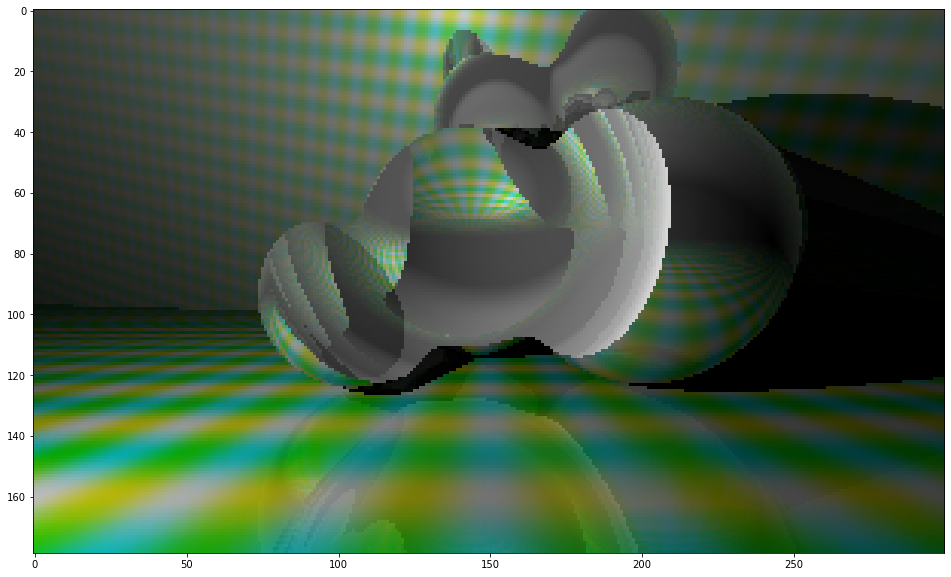

In [346]:
img = render_image(my_camera, my_scene, camera_screen, depth = 16)

#plt.imsave('tmp.png', img)
plt.figure(figsize=(20,10))
plt.imshow(img)

0 %


<ipython-input-310-b7a2e57cf472>:44: RuntimeWarning: invalid value encountered in double_scalars
  return numerator/denominator


5.0 % dt - 1021.2094459533691
10.0 % dt - 1349.4469318389893
15.0 % dt - 947.7656238079071
20.0 % dt - 817.1243507862091
25.0 % dt - 765.61909532547
30.0 % dt - 656.4261348247528
35.0 % dt - 661.6231226921082
40.0 % dt - 694.2213022708893
45.0 % dt - 792.8555002212524
50.0 % dt - 764.7326068878174
55.00000000000001 % dt - 939.7490787506104
60.0 % dt - 1179.9909269809723
65.0 % dt - 1512.6139388084412
70.0 % dt - 1868.7124042510986
75.0 % dt - 2064.9014189243317
80.0 % dt - 1716.1474649906158
85.0 % dt - 1287.622881412506
90.0 % dt - 1067.4598634243011
95.0 % dt - 920.7405750751495
100 % time - 21881.406647205353


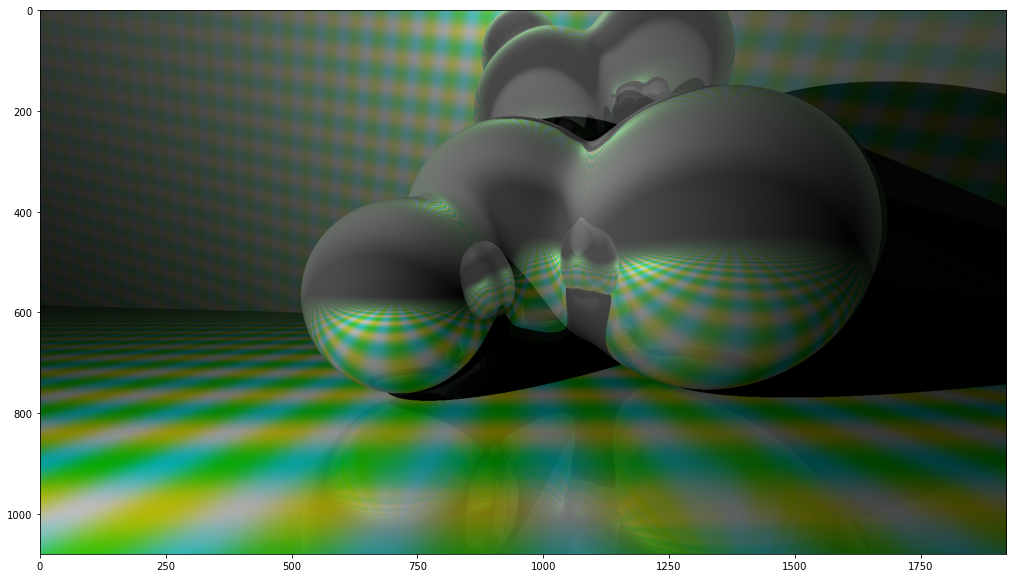

In [327]:
my_camera = empty()
my_camera.position = np.array([0.0, 4.4, -0.8])
my_camera.orientate = np.array([0.1, 0, 0])
my_camera.dx = np.array([0.0, 0.0, 1.0])
my_camera.dy = np.array([0.0, 1.0, 0.0])
my_camera.delta = 0.00015625

camera_screen = empty()
camera_screen.w = 1920
camera_screen.h = 1080

img = render_image(my_camera, my_scene, camera_screen, depth = 16)

plt.imsave('my_image2.png', img)
plt.figure(figsize=(20,10))
plt.imshow(img)

### Немного кода для теста

In [282]:
tmpa = SDF_function(lambda x,y : ((x+1)*(x+1)+(y-1)*(y-1))**(0.5)-1.4)
tmpb = SDF_function(lambda x,y : ((x+1)*(x+1)+(y+1)*(y+1))**(0.5)-1.4)
tmpc = SDF_function(lambda x,y : ((x-1)*(x-1)+(y-1)*(y-1))**(0.5)-1.4)
tmpd = SDF_function(lambda x,y : ((x-1)*(x-1)+(y+1)*(y+1))**(0.5)-1.4)
tmp4 = tmpa + tmpb + tmpc + tmpd
tmp4 = smooth_SDF([tmpa, tmpb, tmpc, tmpd], -1)

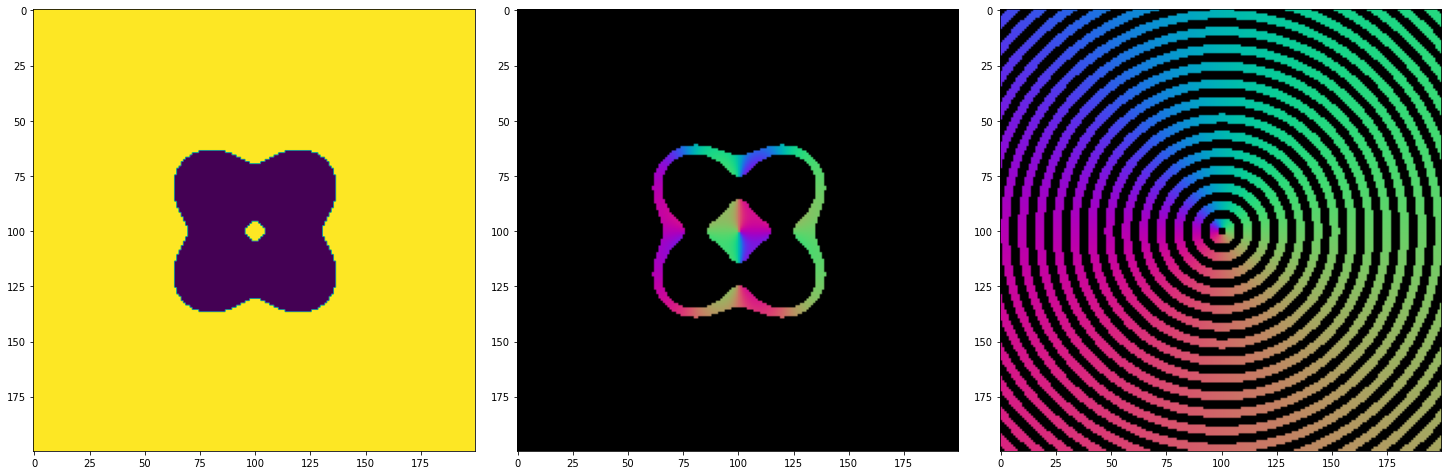

In [283]:
import matplotlib.gridspec as gridspec
scale = 20
t_img = np.zeros((10*scale, 10*scale))
tmp_img = np.zeros((10*scale, 10*scale, 3))
dir_img = np.zeros((10*scale, 10*scale, 3))
for i in range(10*scale):
    for k in range(10*scale):
        x = i/scale - 5
        y = k/scale - 5
        if tmp4(x, y) > 0:
            t_img[i][k] = 1
        else:
            t_img[i][k] = -1
        if  -0.1 < tmp4(x, y) < 0.1:
            tmp_img[i][k][0] = (tmp4(x+tiny_eps,y)-tmp4(x-eps,y))/(2*eps)
            tmp_img[i][k][1] = (tmp4(x,y+eps)-tmp4(x,y-eps))/(2*eps)
            tmp_img[i][k] = np.ones(3) + normalize(tmp_img[i][k])
            tmp_img[i][k] = normalize(tmp_img[i][k])
        if -0.707 < np.cos(8*(x*x+y*y)**0.5) < 0.707:
            dir_img[i][k] = np.array([x,y,0])
            dir_img[i][k] = np.ones(3) + normalize(dir_img[i][k])
            dir_img[i][k] = normalize(dir_img[i][k])
            
            
fig2 = plt.figure(constrained_layout=True, figsize=(20,10))
spec2 = gridspec.GridSpec(nrows=1, ncols=3, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[0, 2])
f2_ax1.imshow(t_img)
f2_ax2.imshow(tmp_img)
f2_ax3.imshow(dir_img)